# Data Pre-proccesing Step

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../model_evaluation')

path = '../../codon-usage-data-set/'
df = pd.read_csv(path + 'codon_usage.csv', low_memory = False)

# removing missing value -----------------------
df = df[pd.to_numeric(df['UUU'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['UUC'], errors='coerce').notnull()]

df.UUU = df.UUU.astype('float64')
df.UUC = df.UUC.astype('float64')
# ----------------------------------------------

# avoid any DNA types specified by the integers greater than 2
df = df[df.DNAtype <= 2]

# Remove plm kingdom
df = df[df.Kingdom != 'plm']

# Convert the type of target attributes to categorical (as opposed to 'str' or 'int') 
df.Kingdom = df.Kingdom.astype('category')
df.DNAtype = df.DNAtype.astype('category')

# Discard the genome entries with Ncodons less than 1000
df = df[df.Ncodons > 1000]

# Replace 'xxx' (where ‘xxx’ is one of ‘pln’, ‘inv’, ‘vrt’, ‘mam’, ‘rod’, or ‘pri’) by 'euk'
df['Kingdom'] = df['Kingdom'].replace(
                      {'pln' : 'euk' ,
                       'inv' : 'euk' ,
                       'vrt' : 'euk' ,
                       'mam' : 'euk' ,
                       'rod' : 'euk' ,
                       'pri' : 'euk' 
                      })

df = df.reset_index(drop=True)
df.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


## Kingdom Class Distribution

In [2]:
df.groupby('Kingdom').size()

Kingdom
arc     126
bct    2916
phg     220
euk    6859
vrl    2831
dtype: int64

## DNAtype Class Distribution

In [3]:
df.groupby('DNAtype').size()

DNAtype
0    9244
1    2899
2     809
dtype: int64

### Tuning the Random Forest Ensemble with hyper-parameter `max_features` 

In [4]:
# Tuning the hyper-parameter (max_features of the random_forest_classifier)
from rf_training import rf_training
from KFold import KFold

class_vars_kingdom = pd.Series(['arc', 'bct', 'phg', 'euk', 'vrl'], dtype='category')
class_vars_dnatype = pd.Series([0, 1, 2], dtype = 'category')
codon_columns = [c for c in df.columns if c not in ['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']]

kfold = KFold(5, shuffle = True, random_state = 1)
df_split = kfold.split(df) 

### Model Tuning For Kingdom Classification

In [5]:
# Performing 5-fold cross-validation for Kingdom Classification
acc_train_kingdom = np.zeros((64,), dtype='float32')
acc_test_kingdom = np.zeros((64,), dtype='float32')
max_features = np.linspace(1,64,64, dtype='int8')
for i in range(1, 65):
    tot_train = 0
    tot_test = 0
    for idx_train, idx_test in df_split:
        X_train = df.loc[idx_train, codon_columns]
        y_train = df.loc[idx_train, 'Kingdom']
        X_test = df.loc[idx_test, codon_columns]
        y_test = df.loc[idx_test, 'Kingdom']
        train, test = rf_training(class_vars_kingdom, X_train, y_train, X_test, y_test, i, random_state = 1)
        tot_train += train
        tot_test += test
    acc_train_kingdom[i-1] = tot_train / 5
    acc_test_kingdom[i-1] = tot_test / 5

### Model Tuning For DNAtype Classification

In [27]:
# Performing 5-fold cross-validation for DNAtype Classification
acc_train_dnatype = np.zeros((64,), dtype='float32')
acc_test_dnatype = np.zeros((64,), dtype='float32')

for i in range(1, 65):
    tot_train = 0
    tot_test = 0
    for idx_train, idx_test in df_split:
        X_train = df.loc[idx_train, codon_columns]
        y_train = df.loc[idx_train, 'DNAtype']

        X_test = df.loc[idx_test, codon_columns]
        y_test = df.loc[idx_test, 'DNAtype']

        train, test = rf_training(class_vars_dnatype, X_train, y_train, X_test, y_test, i, random_state = 1)
        tot_train += train
        tot_test += test
    acc_train_dnatype[i-1] = tot_train / 5
    acc_test_dnatype[i-1] = tot_test / 5

### Draw the accuracy vs max_features plot

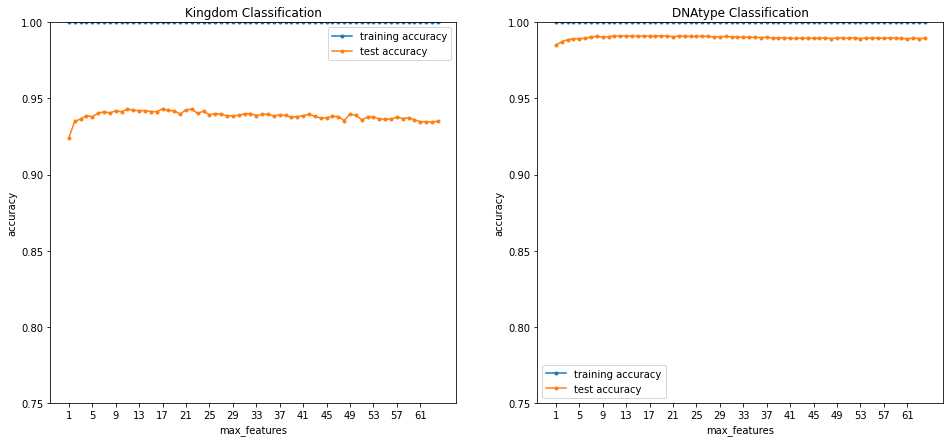

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))

ax1.set_title('Kingdom Classification')
ax1.set_xlabel('max_features')
ax1.set_ylabel('accuracy')
ax1.set_xticks(max_features[::4])    
ax1.set_ylim(0.75,1)

ax1.plot(max_features, acc_train_kingdom, marker='.', label= 'training accuracy')
ax1.plot(max_features, acc_test_kingdom, marker='.', label= 'test accuracy')
ax1.legend()

ax2.set_title('DNAtype Classification')
ax2.set_xlabel('max_features')
ax2.set_ylabel('accuracy')
ax2.set_xticks(max_features[::4])    
ax2.set_ylim(0.75,1)

ax2.plot(max_features, acc_train_dnatype, marker='.', label= 'training accuracy')
ax2.plot(max_features, acc_test_dnatype, marker='.', label= 'test accuracy')
ax2.legend()

plt.show()

In [40]:
# Determine the optimal max_features value for Kingdom Classification
print('Kingdom Classification')
opt_max_features_kingdom = np.argmax(acc_test_kingdom)+1
opt_accuracy_kingdom = acc_test_kingdom[opt_max_features_kingdom-1]
print(f"optimal max_features: {opt_max_features_kingdom}")
print(f"optimal test accuracy: {opt_accuracy_kingdom:.4f}")
print(f"optimal train accuracy: {acc_train_kingdom[opt_max_features_kingdom-1]}")
print('-------------------------------')
print('DNAtype Classification')
opt_max_features_dnatype = np.argmax(acc_test_dnatype)+1
opt_accuracy_dnatype = acc_test_dnatype[opt_max_features_dnatype-1]
print(f"optimal max_features: {opt_max_features_dnatype}")
print(f"optimal test accuracy: {opt_accuracy_dnatype:.4f}")
print(f"optimal train accuracy: {acc_train_dnatype[opt_max_features_dnatype-1]:.4f}")
print('-------------------------------')

Kingdom Classification
optimal max_features: 17
optimal test accuracy: 0.9433
optimal train accuracy: 1.0
-------------------------------
DNAtype Classification
optimal max_features: 19
optimal test accuracy: 0.9912
optimal train accuracy: 0.9999
-------------------------------


The number of trees is initialized to be 100 for building the random forest model, and arrived at reduced branches based on the random feature selection in the tree splitting process. Using 5-fold cross-validation, we tuned the `max_features` (number of variables used for splitting) parameter between 1 and 64
</br>
</br>
**Kingdom Classification**
</br>
best performance is for **17 max_features** 
</br>
`max_features:17 ,training-accuracy:1.0, test-accuracy:0.9433`
</br>
**DNAtype Classification**
</br>
best performance is for **19 max_features**
</br>
`max_features:19 ,training-accuracy:0.9999, test-accuracy:0.9912`

In [41]:
print(f'max_features:{max_features[16]} ,training-accuracy:{acc_train_kingdom[16]:.4}, test-accuracy:{acc_test_kingdom[16]:.4}')
print(f'max_features:{max_features[18]} ,training-accuracy:{acc_train_dnatype[18]:.4}, test-accuracy:{acc_test_dnatype[18]:.4}')

max_features:17 ,training-accuracy:1.0, test-accuracy:0.9433
max_features:19 ,training-accuracy:0.9999, test-accuracy:0.9912


### Build the respective optimal models

In [42]:
from sklearn.ensemble import RandomForestClassifier

X = df.loc[:,codon_columns]
y_kingdom = df['Kingdom']
y_dnatype = df['DNAtype']
# Optimal Model for Kingdom classification
model_rf_kingdom = RandomForestClassifier(max_features = 17, class_weight = 'balanced')
model_rf_kingdom.fit(X, y_kingdom)

RandomForestClassifier(class_weight='balanced', max_features=17)

In [43]:
# Optimal Model for DNAtype Classification
model_rf_dnatype = RandomForestClassifier(max_features = 19, class_weight = 'balanced')
model_rf_dnatype.fit(X, y_dnatype)

RandomForestClassifier(class_weight='balanced', max_features=19)

### Apply the models on the data-set and draw their ROC curves (i.e. FPR vs TPR curve) to check their class-wise performance 

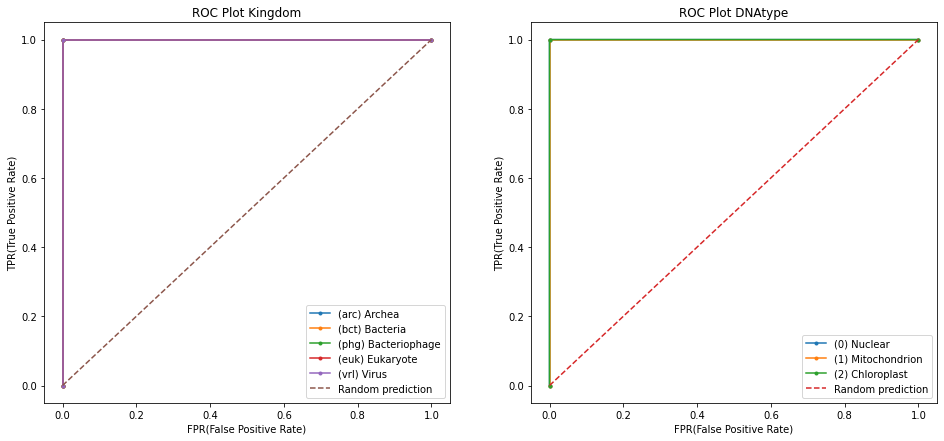

In [45]:
from sklearn.metrics import roc_curve

# Kingdom Classification ROC Plot ----------------------------------

n = len(y_kingdom)
m = len(class_vars_kingdom)

# Run the model on the data-set
y_pred_kingdom = model_rf_kingdom.predict(X)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))

ax1.set_title('ROC Plot Kingdom')

ax1.set_xlabel('FPR(False Positive Rate)')
ax1.set_ylabel('TPR(True Positive Rate)')

_y = np.ones((n,),dtype="int8")
_y_pred = np.ones((n,),dtype="int8")
first = True
for i in range(m):
    if not first:
        _y = np.ones((n,),dtype="int8")
        _y_pred = np.ones((n,),dtype="int8")
    class_name = class_vars_kingdom[i]
    for j in range(n):
        if y_kingdom[j] != class_name:
            _y[j] = 0
        if y_pred_kingdom[j] != class_name:
            _y_pred[j] = 0
    rf_fpr, rf_tpr, _ = roc_curve(_y, _y_pred)
    match class_name:
        case 'arc':
            class_name = '(arc) Archea'
        case 'bct':
            class_name = '(bct) Bacteria'
        case 'phg':
            class_name = '(phg) Bacteriophage'
        case 'euk':
            class_name = '(euk) Eukaryote'
        case 'vrl' :
            class_name = '(vrl) Virus'
    ax1.plot(rf_fpr, rf_tpr, marker='.', label= class_name)
    first = False

random_fpr, random_tpr, _ = roc_curve(_y, np.zeros((n,), dtype='int8'))
ax1.plot(random_fpr, random_tpr, linestyle='--', label='Random prediction')
ax1.legend()

# DNAtype Classification ROC Plot ----------------------------------

m = len(class_vars_dnatype)

# Run the model on the data-set 
y_pred_dnatype = model_rf_dnatype.predict(X)

ax2.set_title('ROC Plot DNAtype')
ax2.set_xlabel('FPR(False Positive Rate)')
ax2.set_ylabel('TPR(True Positive Rate)')

_y = np.ones((n,),dtype="int8")
_y_pred = np.ones((n,),dtype="int8")
first = True
for i in range(m):
    if not first:
        _y = np.ones((n,),dtype="int8")
        _y_pred = np.ones((n,),dtype="int8")
    
    class_name = class_vars_dnatype[i]
    for j in range(n):
        if y_dnatype[j] != class_name:
            _y[j] = 0
        if y_pred_dnatype[j] != class_name:
            _y_pred[j] = 0
    rf_fpr, rf_tpr, _ = roc_curve(_y, _y_pred)
    match class_name:
        case 0:
            class_name = '(0) Nuclear'
        case 1:
            class_name = '(1) Mitochondrion'
        case 2:
            class_name = '(2) Chloroplast'
    ax2.plot(rf_fpr, rf_tpr, marker='.', label= class_name)
    first = False

ax2.plot(random_fpr, random_tpr, linestyle='--', label='Random prediction')

ax2.legend()
plt.show()

Again we make the following inferences:
</br>
</br>
**Kingdom Classification**
</br>
The model works quite well with very high performance
</br>
**DNAtype Classification**
</br>
The model works quite well with very high performance
</br>

### Statistical Scores of the models built 

In [46]:
# Statistical Measures
import eval_metrics

print('Kingdom Classification-------------------')
conf_matrix = eval_metrics.confusion_matrix(y_kingdom, y_pred_kingdom, class_vars_kingdom)
print('Accuracy:%.4f' %eval_metrics.accuracy(conf_matrix))
print('Precision:%.4f' %eval_metrics.precision(conf_matrix, class_vars_kingdom))
print('Recall:%.4f' %eval_metrics.recall(conf_matrix, class_vars_kingdom))

conf_matrix = eval_metrics.confusion_matrix(y_dnatype, y_pred_dnatype, class_vars_dnatype)
print('DNAtype Classification-------------------')
print('Accuracy:%.4f' %eval_metrics.accuracy(conf_matrix))
print('Precision:%.4f' %eval_metrics.precision(conf_matrix, class_vars_dnatype))
print('Recall:%.4f' %eval_metrics.recall(conf_matrix, class_vars_dnatype))

Kingdom Classification-------------------
Accuracy:1.0000
Precision:1.0000
Recall:1.0000
DNAtype Classification-------------------
Accuracy:0.9999
Precision:0.9999
Recall:0.9999
